The link for the original Assignment4 document by Alexey Grigorev:

https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/course-zoomcamp/cohorts/2022/04-evaluation/homework.md

## Dataset

In this homework, we will use Credit Card Data from book "Econometric Analysis".

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
```
The goal of this homework is to inspect the output of different evaluation metrics by creating a classification model (target column `card`). 


If you have ties, select the score with the lowest std. If you still have ties, select the smallest C



### Environments

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wget

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold

%matplotlib inline

In [166]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv'

# use this one time
#wget.download(url) 

In [167]:
df = pd.read_csv('AER_credit_card_data.csv')

## Preparation

* Create the target variable by mapping `yes` to 1 and `no` to 0. 
* Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`.

* Create the target variable by mapping `yes` to 1 and `no` to 0. 

In [168]:
df.card.value_counts()

yes    1023
no      296
Name: card, dtype: int64

In [169]:
df['card'] = df.card.map({'yes' : 1, 'no': 0})

In [170]:
df.card.value_counts()

1    1023
0     296
Name: card, dtype: int64

* Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`.

In [171]:
df_full_train , df_test = train_test_split(df, test_size=0.2, random_state=1)

In [172]:
df_train, df_val = train_test_split(df_full_train, test_size= 0.25, random_state=1)

In [173]:
df_train.shape[0], df_val.shape[0], df_test.shape[0] #  splitting is successful

(791, 264, 264)

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `card` variable.
* Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenditure']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `reports`
- `dependents`
- `active`
- `share`

In [174]:
numFeatures = ['reports', 'dependents', 'active', 'share']
for i in numFeatures:
    score = roc_auc_score(df_train['card'], df_train[i])
    if score < 0.5:
        score = roc_auc_score(df_train['card'], -df_train[i])
    print(i, score) 
    
# highest auc is share with 0.98

reports 0.7166629860689376
dependents 0.5327757227773791
active 0.6043173411362006
share 0.989183643423692


## Training the model

From now on, use these columns only:

```
["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [175]:
y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

In [176]:
dict_train = df_train.to_dict(orient= 'records')
dict_val = df_val.to_dict(orient= 'records')
dict_test = df_test.to_dict(orient= 'records')

dv = DictVectorizer(sparse= False)

X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)
X_test = dv.transform(dict_test)

In [177]:
dv.feature_names_

['active',
 'age',
 'dependents',
 'expenditure',
 'income',
 'majorcards',
 'months',
 'owner=no',
 'owner=yes',
 'reports',
 'selfemp=no',
 'selfemp=yes',
 'share']

In [178]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.9696969696969697

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.615
- 0.515
- 0.715
- 0.995

In [179]:
y_pred = model.predict_proba(X_val)[:, 1]

In [180]:
roc_auc_score(y_val, y_pred).round(3) # auc score is 0.995

0.995

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them


At which threshold precision and recall curves intersect?

* 0.1
* 0.3
* 0.6
* 0.8

In [181]:
def confusion_matrix(y_true, y_pred):
    threshold = np.arange(0, (1+0.01), 0.01)
    scores = []
    for t in thresholds:
        actual_pos = (y_true == 1)
        actual_neg = (~actual_pos)
        predict_pos = (y_pred >= t)
        predict_neg = (~predict_pos)
        
        tp = (actual_pos & predict_pos).sum()
        tn = (actual_neg & predict_neg).sum() 
        fp = (actual_neg & predict_pos).sum()
        fn = (actual_pos & predict_neg).sum()
        
        scores.append((t, tp, fp, fn, tn))
    
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    df_scores['recall']  = df_scores['tp'] / (df_scores['tp'] + df_scores['fn'])
    df_scores['precision'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fp'])
    
    return df_scores

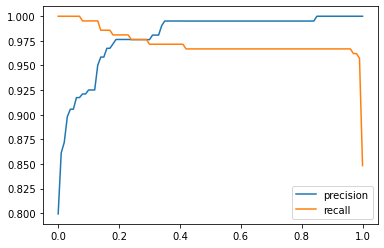

In [182]:
df_scores = confusion_matrix(y_val, y_pred)


plt.plot(df_scores.threshold, df_scores.precision, label='precision')
plt.plot(df_scores.threshold, df_scores.recall, label='recall')



plt.legend()
plt.show()
# it is about 0.3

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing $F_1$:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

At which threshold F1 is maximal?

- 0.1
- 0.4
- 0.6
- 0.7

In [183]:
p = df_scores.precision
r = df_scores.recall
df_scores['F1'] = (2 * p * r) / (p+ r)
df_scores[df_scores['F1'].max() ==df_scores['F1']] # our answer is 0.4

,threshold,tp,fp,fn,tn,recall,precision,F1
35,0.35,205,1,6,52,0.971564,0.995146,0.983213
36,0.36,205,1,6,52,0.971564,0.995146,0.983213
37,0.37,205,1,6,52,0.971564,0.995146,0.983213
38,0.38,205,1,6,52,0.971564,0.995146,0.983213
39,0.39,205,1,6,52,0.971564,0.995146,0.983213
40,0.40,205,1,6,52,0.971564,0.995146,0.983213
41,0.41,205,1,6,52,0.971564,0.995146,0.983213


## Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the AUC scores across different folds?

- 0.003
- 0.014
- 0.09
- 0.24

In [195]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [196]:
def train_predict(df_train, df_val, y_train, y_val):
    del df_train['card']
    del df_val['card']
    
    dict_train = df_train.to_dict(orient = 'records')
    dict_val = df_val.to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse= False)
    X_train = dv.fit_transform(dict_train)
    X_val = dv.transform(dict_val)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_val)[:, 1]
    
    return y_pred

In [199]:
scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.card.values
    y_val = df_val.card.values
    
    y_pred = train_predict(df_train, df_val, y_train, y_val)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores))) # the answer is 0.003

0.996 +- 0.003


## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

In [204]:
def train_predict(df_train, df_val, y_train, y_val, C):
    del df_train['card']
    del df_val['card']
    
    dict_train = df_train.to_dict(orient = 'records')
    dict_val = df_val.to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse= False)
    X_train = dv.fit_transform(dict_train)
    X_val = dv.transform(dict_val)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_val)[:, 1]
    
    return y_pred

In [209]:
C = [0.01, 0.1, 1, 10]
for c in C:
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        y_pred = train_predict(df_train, df_val, y_train, y_val, c)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('%.f : %.3f +- %.3f' % (c ,np.mean(scores), np.std(scores))) # the answer is 1 

0 : 0.992 +- 0.006
0 : 0.995 +- 0.004
1 : 0.996 +- 0.003
10 : 0.996 +- 0.003


## Deadline

The deadline for submitting is October 3 (Monday), 23:00 CEST.